In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams.update({'font.size': 12})

In [2]:
import numpy as np
import zarr
import matplotlib.pyplot as plt

In [3]:
from msi_zarr_analysis.utils.autocrop import autocrop
from msi_zarr_analysis.utils.iter_chunks import iter_loaded_chunks

### Dataset

In [4]:
r14 = zarr.open_group("../datasets/comulis14.zarr/")
r15 = zarr.open_group("../datasets/comulis15.zarr/")

r14_norm_2305 = zarr.open_group("../datasets/comulis14_norm_2305.zarr/")
r15_norm_2305 = zarr.open_group("../datasets/comulis15_norm_2305.zarr/")

### Normalization at m/z=317.176

In [5]:
def show_normalization(
    n_spectra: int,
    *,
    figsize: tuple,
    **z_group_dict,
) -> None:
    assert len(z_group_dict) > 0, "needs at least one dataset"

    lo, hi = 305, 330

    fig, axes = plt.subplots(
        nrows=len(z_group_dict),
        ncols=n_spectra,
        figsize=figsize,
        sharex=False,  # actually share the axis, but repeating the ticks is prettier
        squeeze=False,
    )
    
    fig.suptitle("Normalization at m/z=317.176")

    for ds_idx, (label, z_group) in enumerate(z_group_dict.items()):
        n_len = z_group["/labels/lengths/0"][0, 0]
        idxs = np.nonzero(n_len)
        selection = np.random.randint(idxs[0].size, size=(n_spectra,))
        
        for point_idx, (y, x) in enumerate(zip(idxs[0][selection], idxs[1][selection])):
            s_len = n_len[y, x]  # they should all have the same lenght, not the case
            s_mzs = z_group["/labels/mzs/0"][:s_len, 0, y, x]
            s_int = z_group["/0"][:s_len, 0, y, x]
            
            ax = axes[ds_idx, point_idx]
            ax.set_title(label + f" {y=}, {x=}")
            sub_range = slice(
                np.searchsorted(s_mzs, lo, side="left"),
                np.searchsorted(s_mzs, hi, side="right"),
            )
            
            s_mzs = s_mzs[sub_range]
            s_int = s_int[sub_range]
            
            ax.stem(s_mzs, s_int, basefmt="none", linefmt="C0-", markerfmt=",")
            #print(f"{i=} {j=}, {s_len=}")
            
            # re-stem the close ones to 1.0
            close_mask = np.abs(s_int - 1.0) < 0.05
            if np.count_nonzero(close_mask) > 1:
                ax.stem(s_mzs[close_mask], s_int[close_mask], basefmt="none", linefmt="none", markerfmt="C3x")
            elif np.count_nonzero(close_mask) == 1:
                ax.stem((s_mzs[close_mask],), (s_int[close_mask],), basefmt="none", linefmt="none", markerfmt="C3x")
            
            ax.stem((317.176,), (0,), basefmt="none", markerfmt="^")
    
            ax.set_ylim((-0.05, 1.2))
    
    fig.tight_layout()

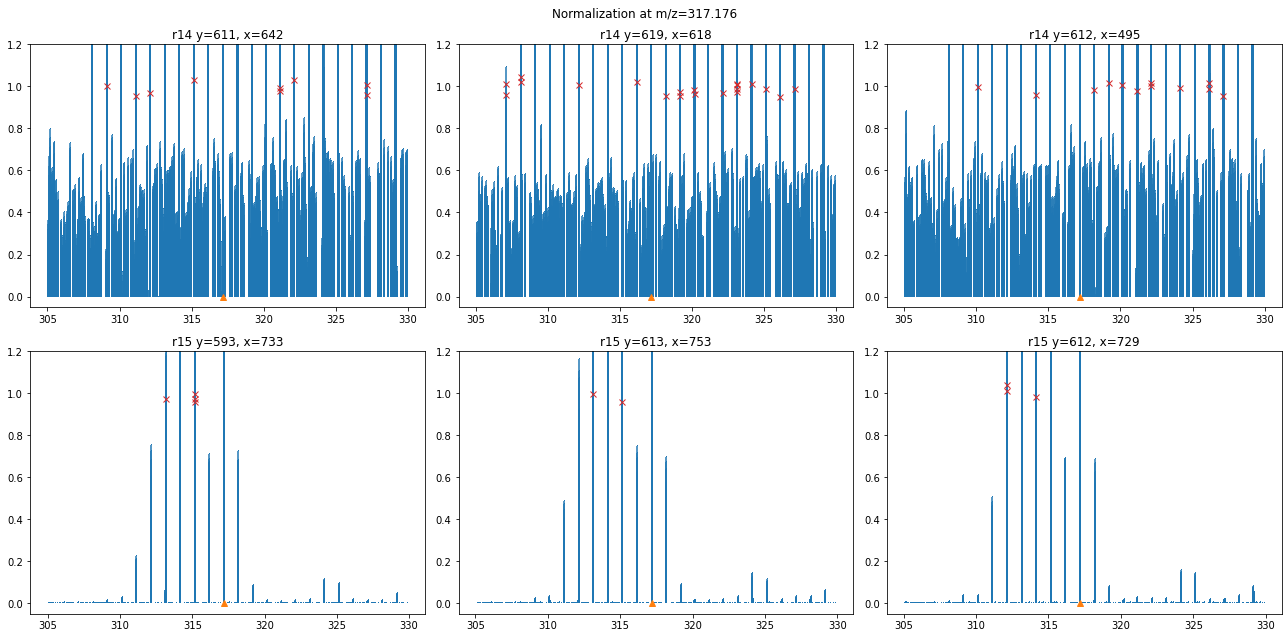

In [6]:
show_normalization(3, figsize=(18, 9), r14=r14_norm_2305, r15=r15_norm_2305)

### Compare m/z axis in region 14 and 15 (2305 vs original)

In [7]:
def check_same_mzs(z_group_left: zarr.Group, z_group_right: zarr.Group, print_: bool = False):
    n_len_left = z_group_left["/labels/lengths/0"][0, 0]
    n_len_right = z_group_right["/labels/lengths/0"][0, 0]

    count_same, count_diff = 0, 0
    
    z_mzs_left = z_group_left["/labels/mzs/0"]
    z_mzs_right = z_group_right["/labels/mzs/0"]
    
    for cy, cx in iter_loaded_chunks(z_mzs_left, skip=2):

        c_len = n_len_left[cy, cx]
        max_len = c_len.max()
        c_mzs_left = z_mzs_left[:max_len, 0, cy, cx]
        c_mzs_right = z_mzs_right[:max_len, 0, cy, cx]
        
        for y, x in zip(*np.nonzero(c_len)):

            if (c_mzs_left[:, y, x] == c_mzs_right[:, y, x]).all():
                count_same += 1
                if print_:
                    print(f"({cy.start + y}, {cx.start + x})")
            else:
                count_diff += 1
    
    return count_same, count_diff

In [ ]:
check_same_mzs(r14, r14_norm_2305)

In [8]:
check_same_mzs(r15, r15_norm_2305)

(1238, 0)

### Image ion at m/z = 317.176

In [49]:
def get_window(point: "tuple[int, int]", shape: "tuple[int, int]", chunks: "tuple[int, int]") -> "tuple[slice, slice]":
    ""
    chunk_idx = [p // c for p, c in zip(point, chunks)]
    lo_idx = [i * c for i, c in zip(chunk_idx, chunks)]
    hi_idx = [min(l + c, s) for c, l, s in zip(chunks, lo_idx, shape)]
    
    return tuple(slice(lo, hi) for lo, hi in zip(lo_idx, hi_idx))

In [110]:
def get_image_ion(dataset: zarr.Group, mz_val: float, mz_tol: float, roi=None) -> np.ndarray:    
    z_int = dataset["/0"]
    z_mzs = dataset["/labels/mzs/0"]
    z_len = dataset["/labels/lengths/0"]
    
    n_len = z_len[0, 0]  # load all lengths
    
    if roi is None:
        roi = (slice(z_int.shape[-2]), slice(z_int.shape[-1]))
        
    img = np.zeros(n_len.shape, dtype=z_int.dtype)
    
    for cy, cx in iter_loaded_chunks(z_int, *roi, skip=2):
        c_len = n_len[cy, cx]
        max_len = c_len.max()

        c_int = z_int[:max_len, 0, cy, cx]
        c_mzs = z_mzs[:max_len, 0, cy, cx]
        
        for y, x in zip(*np.nonzero(c_len)):
            img_y = cy.start + y
            img_x = cx.start + x

            s_len = c_len[y, x]
            s_mzs = c_mzs[:s_len, y, x]
            
            val = 0.0
            
            # idx = np.searchsorted(s_mzs, mz_val)
            # p_mzs = s_mzs[idx]
            # if p_mzs >= mz_val - mz_tol and p_mzs <= mz_val + mz_tol:
            #     val = c_int[idx, y, x]

            lo = np.searchsorted(s_mzs, mz_val - mz_tol, side="left")
            hi = np.searchsorted(s_mzs, mz_val + mz_tol, side="right")
            range_int = c_int[lo:hi, y, x]
            
            if range_int.size > 0:
                val = range_int.mean()
                # val = range_int.sum()
                # val = range_int.sum() / mz_tol / 2.0
            
            img[img_y, img_x] = val

    img = np.where(n_len > 0, img, np.nan)
    
    return img[roi]

In [90]:
def plot_ion_image(dataset: zarr.Group, mz_val: float, mz_tol: float, name: str, figsize: tuple, coordinates=None):
    
    if coordinates is None:
        # roi = autocrop(dataset["/labels/lengths/0"][0, 0])
        roi = None
    else:
        roi = get_window(coordinates, dataset["/0"].shape[-2:], dataset["/0"].chunks[-2:])
    
    ion_image = get_image_ion(dataset, mz_val, mz_tol, roi=roi)

    plt.figure(figsize=figsize)
    current_cmap = mpl.cm.get_cmap().copy()
    current_cmap.set_bad(color='black')

    plt.imshow(ion_image, interpolation="nearest", cmap=current_cmap)

    plt.title(name + f", at m/z = {mz_val} +- {mz_tol}")
    plt.colorbar()

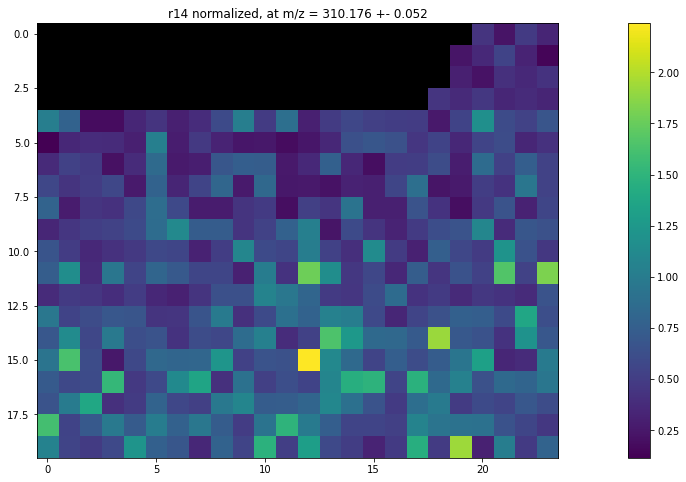

In [115]:
plot_ion_image(r14_norm_2305, 310.176, 5.2e-2, "r14 normalized", figsize=(25, 8), coordinates=(600, 600))#(35, 160))

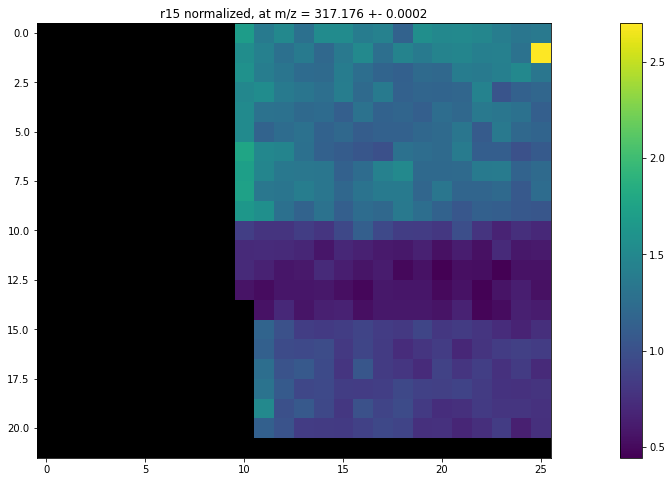

In [102]:
plot_ion_image(r15_norm_2305, 317.176, 2e-4, "r15 normalized", figsize=(25, 8), coordinates=(600, 720))

### Plot normalization ratio at given mzs (**region 14 and 15 only**)

In [117]:
def plot_ion_image_ratio(dataset_raw: zarr.Group, dataset_normalized: zarr.Group, mz_val: float, mz_tol: float, name: str, figsize: tuple, coordinates=None):
    
    if coordinates is None:
        roi = None
    else:
        roi = get_window(coordinates, dataset_raw["/0"].shape[-2:], dataset_raw["/0"].chunks[-2:])
    
    ion_image_normalized = get_image_ion(dataset_normalized, mz_val, mz_tol, roi=roi)
    ion_image_raw = get_image_ion(dataset_raw, mz_val, mz_tol, roi=roi)

    plt.figure(figsize=figsize)
    current_cmap = mpl.cm.get_cmap().copy()
    current_cmap.set_bad(color='black')

    plt.imshow(ion_image_raw / ion_image_normalized, interpolation="nearest", cmap=current_cmap)

    plt.title(name + f", at m/z = {mz_val} +- {mz_tol}")
    plt.colorbar()

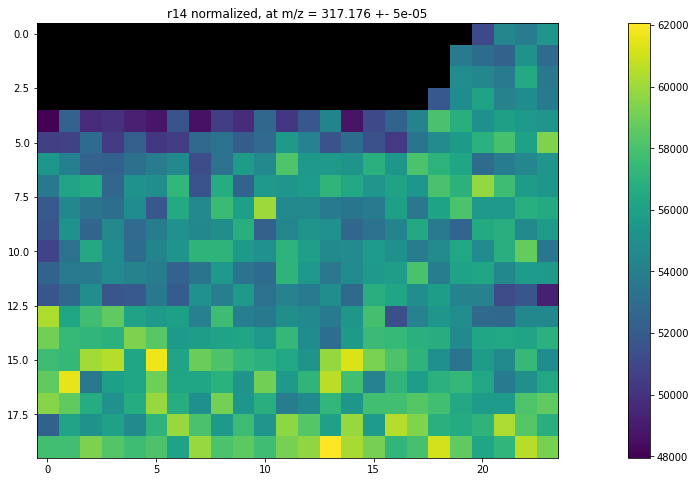

In [127]:
plot_ion_image_ratio(r14, r14_norm_2305, 317.176, 5e-5, "r14 normalized", figsize=(25, 8), coordinates=(600, 600))

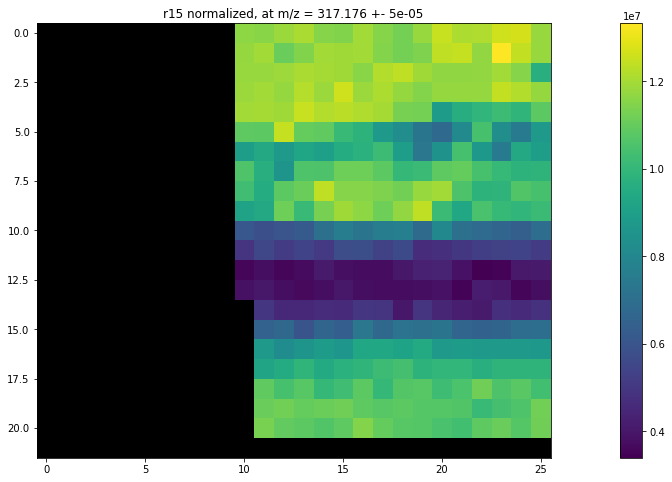

In [126]:
plot_ion_image_ratio(r15, r15_norm_2305, 317.176, 5e-5, "r15 normalized", figsize=(25, 8), coordinates=(600, 720))

### Show spectra ratios (r14&15)

In [128]:
def get_image_ratio(raw: zarr.Group, normalized: zarr.Group, roi=None) -> np.ndarray:    
    z_r_int = raw["/0"]
    z_n_int = normalized["/0"]
    z_len = raw["/labels/lengths/0"]
    
    n_len = z_len[0, 0]  # load all lengths
    
    if roi is None:
        roi = (slice(z_r_int.shape[-2]), slice(z_r_int.shape[-1]))
        
    img = np.zeros(n_len.shape, dtype=z_r_int.dtype)
    
    for cy, cx in iter_loaded_chunks(z_r_int, *roi, skip=2):
        c_len = n_len[cy, cx]
        max_len = c_len.max()

        c_r_int = z_r_int[:max_len, 0, cy, cx]
        c_n_int = z_n_int[:max_len, 0, cy, cx]
        
        for y, x in zip(*np.nonzero(c_len)):
            img_y = cy.start + y
            img_x = cx.start + x

            s_len = c_len[y, x]
            
            s_r_int = c_r_int[:s_len, y, x]
            s_n_int = c_n_int[:s_len, y, x]
            
            img[img_y, img_x] = np.nanmean(s_r_int / s_n_int)

    img = np.where(n_len > 0, img, np.nan)
    
    return img[roi]

In [129]:
def plot_ratio_image(raw: zarr.Group, normalized: zarr.Group, name: str, figsize: tuple, coordinates=None):

    if coordinates is None:
        roi = None
    else:
        roi = get_window(coordinates, raw["/0"].shape[-2:], raw["/0"].chunks[-2:])
    
    ion_image = get_image_ratio(raw, normalized, roi=roi)

    plt.figure(figsize=figsize)
    current_cmap = mpl.cm.get_cmap().copy()
    current_cmap.set_bad(color='black')

    plt.imshow(ion_image, interpolation="nearest", cmap=current_cmap)

    plt.title("image ratio of " + name)
    plt.colorbar()

/tmp/ipykernel_11360/1989486187.py:29: RuntimeWarning: invalid value encountered in true_divide
  img[img_y, img_x] = np.nanmean(s_r_int / s_n_int)


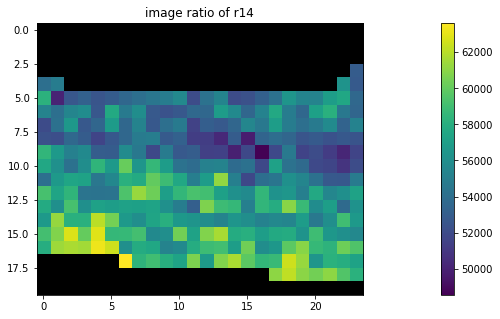

In [139]:
plot_ratio_image(r14, r14_norm_2305, "r14", figsize=(28, 5), coordinates=(600, 530))

/tmp/ipykernel_11360/1989486187.py:29: RuntimeWarning: invalid value encountered in true_divide
  img[img_y, img_x] = np.nanmean(s_r_int / s_n_int)


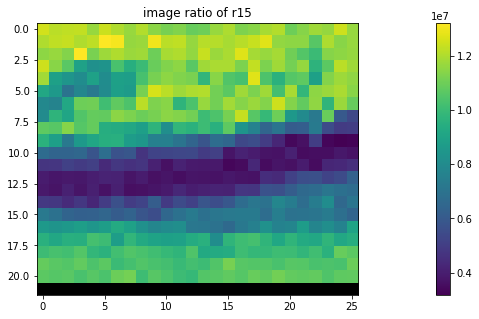

In [135]:
plot_ratio_image(r15, r15_norm_2305, "r15", figsize=(28, 5), coordinates=(600, 740))

### Sanity check the normalization (**region 14 and 15 only**)

In [17]:
def sanity_check_normalization(dataset: zarr.Group, normalized: zarr.Group, n_spectra: int):
    n_len = dataset["/labels/lengths/0"][0, 0]
    idxs = np.nonzero(n_len)
    selection = np.random.randint(idxs[0].size, size=(n_spectra,))
    
    assert np.all(n_len == normalized["/labels/lengths/0"][0, 0]), "region 13 not usable"
    
    z_r_mzs = dataset["/labels/mzs/0"]
    z_n_mzs = normalized["/labels/mzs/0"]
    
    z_r_int = dataset["/0"]
    z_n_int = normalized["/0"]
    
    for y, x in zip(idxs[0][selection], idxs[1][selection]):
        s_len = n_len[y, x]
        s_mzs = z_r_mzs[:s_len, 0, y, x]
        
        s_r_int = z_r_int[:s_len, 0, y, x]
        s_n_int = z_n_int[:s_len, 0, y, x]
        
        ratio = s_r_int / s_n_int
        nan_per = np.isnan(ratio).sum() / ratio.size
        ratio = ratio[~np.isnan(ratio)]
        
        print(f"{y=} {x=:} {nan_per=:.5f} {ratio.mean()=:.2f} {ratio.std()=}")

In [18]:
sanity_check_normalization(r15, r15_norm_2305, 5)

/tmp/ipykernel_11708/4067000137.py:21: RuntimeWarning: invalid value encountered in true_divide
  ratio = s_r_int / s_n_int


y=612 x=729 nan_per=0.18568 ratio.mean()=10272045.34 ratio.std()=0.0
y=612 x=730 nan_per=0.16724 ratio.mean()=10187165.79 ratio.std()=1.862645149230957e-09
y=609 x=746 nan_per=0.18095 ratio.mean()=6756212.56 ratio.std()=4.6566128730773926e-09
y=592 x=713 nan_per=0.19822 ratio.mean()=11515078.76 ratio.std()=3.725290298461914e-09
y=594 x=718 nan_per=0.18007 ratio.mean()=11971543.42 ratio.std()=3.725290298461914e-09
